In [1]:
import xarray as xr
from pathlib import Path
from typing import List, Dict, Tuple, NamedTuple, Iterable, Hashable
from datetime import date, timedelta
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from tqdm import tqdm

CMEMS_PATH = Path(r"C:\Users\Casper\OneDrive - Danmarks Tekniske Universitet\SKOLE\Kandidat\Syntese\ProcessedGrids\CMEMS")
MEASURES_PATH = Path(r"C:\Users\Casper\OneDrive - Danmarks Tekniske Universitet\SKOLE\Kandidat\Syntese\ProcessedGrids\MEaSUREs")
PROCESSED = Path(r"C:\Users\Casper\OneDrive - Danmarks Tekniske Universitet\SKOLE\Kandidat\Syntese\ProcessedGrids\Processed_v4_v10")
RAW = Path(r"C:\Users\Casper\Desktop\day_data\Processed_v4")

In [2]:
class MatchedFiles(NamedTuple):
    Date: date
    Measures: Path | None
    Cmems: Path | None
    Processed: Path

    @property
    def ContainsMeasures(self):
        return self.Measures is not None
    
    @property
    def ContainsCmems(self):
        return self.Cmems is not None

    def __repr__(self) -> str:
        repr_str = f"{self.Date}, {self.Processed.name}"
        if self.Measures is not None:
            repr_str += f", {self.Measures.name}"
        if self.Cmems is not None:
            repr_str += f", {self.Cmems.name}"
        return f"MatchedFiles({repr_str})"


class MatchedData(NamedTuple):
    Files: MatchedFiles
    Cmems: xr.Dataset | None
    Processed: xr.Dataset
    Measures: xr.Dataset | None

    @property
    def Date(self):
        return self.Files.Date

    @property
    def ContainsMeasures(self):
        return self.Measures is not None
    
    @property
    def ContainsCmems(self):
        return self.Cmems is not None

    def __repr__(self) -> str:
        repr_str = f"{self.Date}, Processed[Grid]"
        if self.ContainsMeasures:
            repr_str += ", Measures[Grid]"
        if self.ContainsCmems:
            repr_str += ", Cmems[Grid]"
        return f"MatchedData({repr_str})"

def get_dims(data: xr.Dataset, keys: Iterable[Hashable], subtract: Iterable[float]) -> xr.DataArray | None:
    for key, sub in zip(keys, subtract):
        if key in data.coords:
            return data[key] - sub
    return None

def get_extent(data: xr.Dataset) -> Tuple[float, float, float, float]:
    lat = get_dims(data, ['latitude', 'Latitude'], [0, 0])
    lon = get_dims(data, ['longitude', 'Longitude'], [180, 0])
    if lat is None or lon is None:
        raise ValueError(f"data does not contain either a valid dimension")

    return (
        lon.min().item(),
        lon.max().item(),
        lat.min().item(),
        lat.max().item()
    )

def rotate_data(data: xr.DataArray, coord: str, upper_boundary: float):
    new_data = np.empty(data.shape)
    # Assign lower bound
    bool_arr = data[coord] < upper_boundary
    new_data[:, ~bool_arr] = data.isel(**{coord: bool_arr})
    new_data[:, bool_arr] = data.isel(**{coord: ~bool_arr})
    return new_data

def bin_ndarray(ndarray, new_shape, operation='sum'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or averaging.
    Number of output dimensions must match number of input dimensions.
    """
    if not operation.lower() in ['sum', 'mean', 'average', 'avg']:
        raise ValueError("Operation {} not supported.".format(operation))
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape, new_shape))
    compression_pairs = [(d, c//d) for d, c in zip(new_shape, ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        if operation.lower() == "sum":
            ndarray = ndarray.sum(-1*(i+1))
        elif operation.lower() in ["mean", "average", "avg"]:
            ndarray = ndarray.mean(-1*(i+1))
    return ndarray

def processed_to_date(file: Path) -> date:
    year, month, day = file.name.replace('.nc', '').split('_')
    return date(int(year), int(month), int(day))

def cmems_to_date(file: Path) -> date:
    cleaned_filename = file.name.replace('.nc', '').replace('dt_global_allsat_phy_l4_', '')
    date_name = cleaned_filename.split('_')[0]
    return date(int(date_name[:4]), int(date_name[4:6]), int(date_name[6:]))

def measures_to_date(file: Path) -> date:
    date_name = file.name.replace('.nc', '').replace('ssh_grids_v2205_', '')
    return date(int(date_name[:4]), int(date_name[4:6]), int(date_name[6:8]))

def match_files(processed: Path, cmems: Path, measures: Path, processed_glob: str = '*.nc') -> List[MatchedFiles]:
    cmems_files = list(cmems.glob('*.nc'))
    measures_files = list(measures.glob('*.nc'))
    processed_files = list(processed.glob(processed_glob))
    cmems_dates = [cmems_to_date(f) for f in cmems_files]
    measures_dates = [measures_to_date(f) for f in measures_files]
    processed_dates = [processed_to_date(f) for f in processed_files]

    matchedFilesList = []
    for p_date, file in zip(processed_dates, processed_files):
        cmems_date, measures_date = None, None
        if p_date in cmems_dates:
            cmems_date = cmems_files[cmems_dates.index(p_date)]
        if p_date in measures_dates:
            measures_date = measures_files[measures_dates.index(p_date)]
        matchedFilesList.append(MatchedFiles(p_date, measures_date, cmems_date, file))
    matchedFilesList = sorted(matchedFilesList, key = lambda x: x.Date)
    return matchedFilesList

def load_raw(folder: Path, file_date: date, n_days: int) -> xr.Dataset:
    files = []
    for day in range(-n_days, n_days + 1):
        curent_day = file_date + timedelta(days=day)
        files.append(folder / Path(f"{curent_day.year}_{curent_day.month}_{curent_day.day}.nc"))
    return xr.open_mfdataset(files, concat_dim='time', combine='nested', engine='netcdf4')

def load_file(file: MatchedFiles) -> MatchedData:
    cmems, measures = None, None
    processed = xr.open_dataset(file.Processed)
    if file.ContainsCmems:
        cmems = xr.open_dataset(file.Cmems) # type: ignore
    if file.Measures:
        measures = xr.open_dataset(file.Measures) # type: ignore
    return MatchedData(file, cmems, processed, measures)

In [3]:
matched_paths = match_files(PROCESSED, CMEMS_PATH, MEASURES_PATH, '2019_1_2.nc')
data = {matched_path.Date: load_file(matched_path) for matched_path in matched_paths}

In [4]:
n_days = [5, 3, 1]
plot_date = list(data)[0]

processed = data[plot_date].Processed
if (cmems := data[plot_date].Cmems) is None:
    binned_cmems = None
else:
    new_cmems = rotate_data(cmems.sla[0], 'longitude', 180)
    new_shape = (180, 360)
    lat_frac = new_cmems.shape[0]/new_shape[0]
    lon_frac = new_cmems.shape[1]/new_shape[1]
    binned_cmems = bin_ndarray(new_cmems, new_shape, operation='mean')
    print("Found CMEMS")

if (measures := data[plot_date].Measures) is None:
    binned_measures = None
else:
    new_measures = rotate_data(measures.SLA[0], 'Longitude', 180)
    new_shape = (160, 360)
    lat_frac = new_measures.shape[0]/new_shape[0]
    lon_frac = new_measures.shape[1]/new_shape[1]
    binned_measures = bin_ndarray(new_measures, new_shape, operation='mean')
    binned_measures = np.pad(binned_measures, ((10, 10), (0,0)), mode='constant', constant_values=(np.nan,))
    print("Found MEaSUREs")

raws = [load_raw(RAW, plot_date, day) for day in n_days]

Found CMEMS
Found MEaSUREs


100%|██████████| 3/3 [00:13<00:00,  4.61s/it]


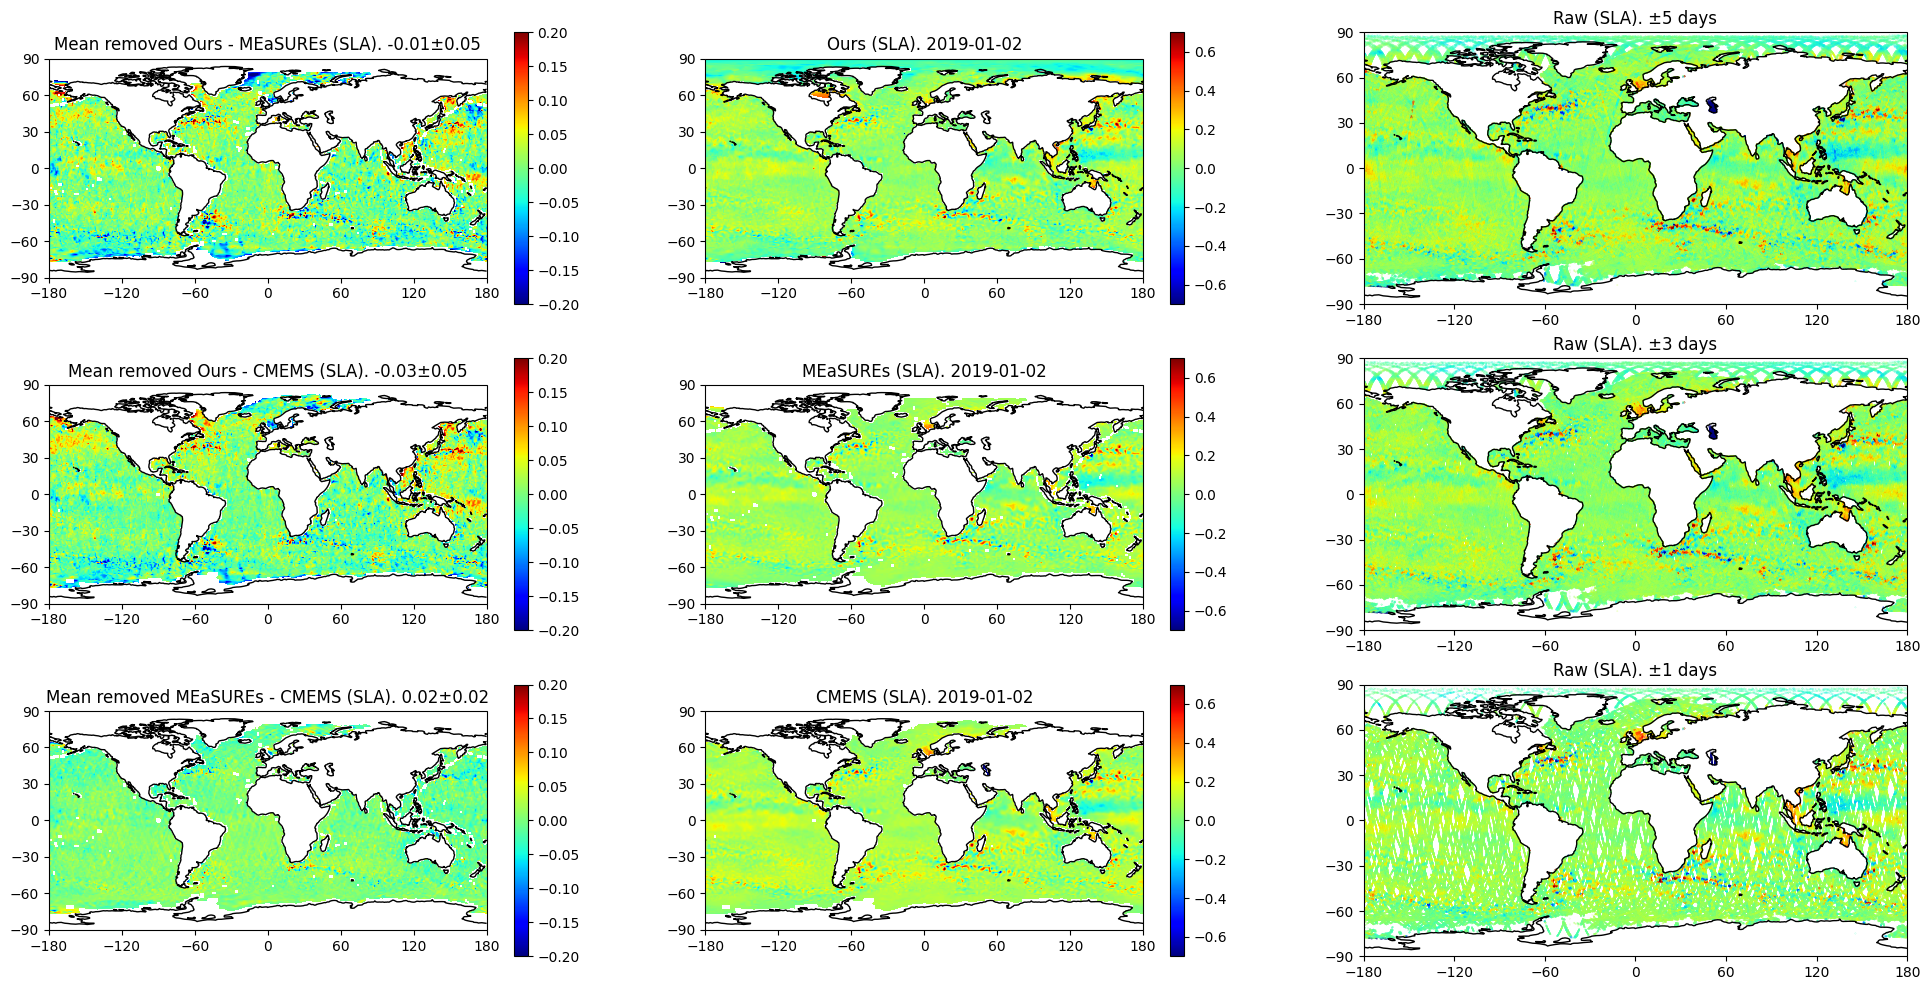

In [14]:
vmin_diff, vmax_diff = -0.2, 0.2
vmin_org, vmax_org = -0.7, 0.7
cmap = 'jet'
binned_data = []
org_data = [processed.sla.data]
diff_names = []
org_names = ["Ours"]


if binned_measures is not None:
    binned_data.append(processed.sla.data - binned_measures)
    org_data.append(binned_measures)
    diff_names.append("Ours - MEaSUREs")
    org_names.append("MEaSUREs")

if binned_cmems is not None:
    binned_data.append(processed.sla.data - binned_cmems)
    org_data.append(binned_cmems)
    diff_names.append("Ours - CMEMS")
    org_names.append("CMEMS")

if binned_measures is not None and binned_cmems is not None:
    binned_data.append(binned_cmems - binned_measures)
    org_data.append("Measures")
    diff_names.append("MEaSUREs - CMEMS")


if len(diff_names) > 0:
    fig, axes = plt.subplots(len(diff_names), 3, figsize=(24, 4*len(diff_names)), subplot_kw=dict(projection=ccrs.PlateCarree()))
    for binned, diff_name, org_d, org_name, raw, n_day, ax in zip(tqdm(binned_data), diff_names, org_data, org_names, raws, n_days, axes):
        
        mean_binned = np.nanmean(binned)
        std_binned = np.nanstd(binned)
        imdiff = ax[0].imshow(binned - mean_binned, origin='lower', extent=get_extent(processed), vmin=vmin_diff, vmax=vmax_diff, cmap=cmap)
        imorg = ax[1].imshow(org_d, origin='lower', extent=get_extent(processed), vmin=vmin_org, vmax=vmax_org, cmap=cmap)
        ax[2].scatter(raw.lon, raw.lat, c=raw.sla, s=0.01, vmin=vmin_org, vmax=vmax_org, cmap=cmap)

        plt.colorbar(imdiff, ax=ax[0])
        plt.colorbar(imorg, ax=ax[1])
        ax[0].set_title(f"Mean removed {diff_name} (SLA). {mean_binned:.2f}±{std_binned:.2f}")
        ax[1].set_title(f"{org_name} (SLA). {plot_date}")
        ax[2].set_title(f"Raw (SLA). ±{n_day} days")

    for ax in axes.flatten():
        ax.coastlines()
        ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
        ax.set_xticks([-180,-120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
        ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    plt.show()